# Baseline models training

Notebook contains training and validation of XGBoost models without any previous experiments on data.  We check 4 different prediction cases:
- All cancer types together, multiclass classification (stages: I, II, III, IV)
- All cancer types together, binary classification (stages: I-III vs IV)
- Only the most numerous types of cancer (each one separately), multiclass classification (stages: I, II, III, IV)
- Only the most numerous types of cancer (each one separately), binary classification (stages: I-III vs IV)

Outcomes can be treated as baseline results.

In [1]:
import os
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

Define random seed to allow reproducibility

In [2]:
random_state = 42
np.random.seed(random_state)

Define directory paths to save results

In [10]:
output_dir_multiclass = '../results/baseline_models/multiclass/'
output_dir_binary = '../results/baseline_models/binary/'

Load training data

In [4]:
data_path = '../data/cleaned'
models_path = '../models'

train = pd.read_csv(os.path.join(data_path, 'train.csv'), sep=';')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Columns: 4398 entries, ID to ENSG00000272168
dtypes: float64(4394), object(4)
memory usage: 21.5+ MB


Define functions for cross-validation in a stratified way: one for hyperparameters optimization (returns only mean score) and a second for validation of the model with best params (returns predictions)

In [5]:
def stratified_cross_val_score(
        estimator,
        df,
        stratification_groups,
        label_col,
        scoring,
        n_splits=5
):
    scores = np.zeros(n_splits)
    skf = StratifiedKFold(n_splits=n_splits)

    for i, (train_index, test_index) in enumerate(skf.split(df, stratification_groups)):
        y = df.loc[:, label_col]
        X = df.drop(columns=[label_col])

        estimator.fit(X=X.iloc[train_index], y=y.iloc[train_index], verbose=False)

        y_true = y.iloc[test_index]
        y_pred = estimator.predict(X.iloc[test_index])
        scores[i] = scoring(list(y_true), y_pred)

    return scores


def stratified_cross_val_predict(
        estimator,
        df,
        stratification_groups,
        label_col,
        n_splits=5
):
    y_pred = np.zeros(len(df))
    skf = StratifiedKFold(n_splits=n_splits)

    for train_index, test_index in skf.split(df, stratification_groups):
        y = df.loc[:, label_col]
        X = df.drop(columns=[label_col])

        estimator.fit(X=X.iloc[train_index], y=y.iloc[train_index], verbose=False)
        y_pred[test_index] = estimator.predict(X.iloc[test_index])

    return y_pred

Define objective function for hyperparameters optimization using Optuna

In [6]:
def objective(trial: optuna.Trial, X_train, stratification_groups, xgb_config, scoring):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 2, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        **xgb_config
    }

    xgb = XGBClassifier(**params)

    scores = stratified_cross_val_score(
        estimator=xgb,
        df=X_train,
        stratification_groups=stratification_groups,
        label_col='Stage',
        scoring=scoring,
        n_splits=4
    )

    return scores.mean()

Define function for plotting confusion matrix

In [7]:
def plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=None):
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g', linewidths=1)
    plt.setp(plt.gca().get_xticklabels(), ha='right', rotation=45)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    plt.title(title, y=1.12, fontsize=12)
    plt.suptitle(scores_subtitle, y=0.08, fontsize=12)

    fig.show()
    
    if output_path is not None:
        fig.savefig(output_path, bbox_inches='tight')

### All cancer types together, multiclass classification (stages: I, II, III, IV)

Extract cancer types and stages to perform cross validation in a stratified way

Remove unnecessary columns: ID, Group, Sex and Age

Encode labels

In [8]:
X_train = train.copy(deep=True)

stratification_groups = X_train.apply(lambda row: f"{row['Group'].replace(' ', '_')}_{row['Stage']}", axis=1)
cancer_types = X_train['Group']
X_train = X_train.loc[:, ~X_train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

labels_encoding = {
    'I': 0,
    'II': 1,
    'III': 2,
    'IV': 3
}
X_train.loc[:, 'Stage'] = X_train['Stage'].map(labels_encoding)

X_train['Stage'].value_counts()

3    372
2    114
1     95
0     59
Name: Stage, dtype: int64

Since the classes are pretty imbalanced we use the weighted-average F1 metric for optimization

In [9]:
xgb_config = {
    'objective': 'multi:softmax',
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'random_state': random_state,
    'num_class': 4,
}

objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=balanced_accuracy_score
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-10-19 11:32:28,265] A new study created in memory with name: no-name-5a9ab56f-25d3-44b6-ad1e-cf9b75d89b16
[I 2023-10-19 11:33:06,440] Trial 0 finished with value: 0.3241316583623586 and parameters: {'n_estimators': 129, 'max_depth': 8, 'learning_rate': 0.32181192158255867, 'subsample': 0.8687281129075164, 'colsample_bytree': 0.5099492643311907, 'gamma': 1.859214250244769}. Best is trial 0 with value: 0.3241316583623586.
[I 2023-10-19 11:33:42,191] Trial 1 finished with value: 0.345078058790142 and parameters: {'n_estimators': 104, 'max_depth': 8, 'learning_rate': 0.213895230115267, 'subsample': 0.8640300918953685, 'colsample_bytree': 0.871274852764751, 'gamma': 4.653689976541463}. Best is trial 1 with value: 0.345078058790142.
[I 2023-10-19 11:33:58,447] Trial 2 finished with value: 0.3681795965015022 and parameters: {'n_estimators': 63, 'max_depth': 2, 'learning_rate': 0.4824565444594585, 'subsample': 0.9529142959677811, 'colsample_bytree': 0.8660515728629412, 'gamma': 2.24908

[I 2023-10-19 11:43:32,657] Trial 25 finished with value: 0.36560346437267416 and parameters: {'n_estimators': 30, 'max_depth': 3, 'learning_rate': 0.2873972497080084, 'subsample': 0.6445201143570908, 'colsample_bytree': 0.850751659610034, 'gamma': 0.5059697956735598}. Best is trial 19 with value: 0.38456491513499336.
[I 2023-10-19 11:43:47,116] Trial 26 finished with value: 0.36362993239754743 and parameters: {'n_estimators': 49, 'max_depth': 2, 'learning_rate': 0.36899315740294547, 'subsample': 0.750381061361279, 'colsample_bytree': 0.8877034885924827, 'gamma': 1.149891160811595}. Best is trial 19 with value: 0.38456491513499336.
[I 2023-10-19 11:44:14,220] Trial 27 finished with value: 0.36669640593448904 and parameters: {'n_estimators': 74, 'max_depth': 3, 'learning_rate': 0.44683594361773793, 'subsample': 0.7238037499592439, 'colsample_bytree': 0.9904910436116068, 'gamma': 0.05856039036548921}. Best is trial 19 with value: 0.38456491513499336.
[I 2023-10-19 11:44:42,514] Trial 28 

[I 2023-10-19 11:51:09,379] Trial 50 finished with value: 0.38667032267786916 and parameters: {'n_estimators': 26, 'max_depth': 3, 'learning_rate': 0.4974553773511231, 'subsample': 0.8913625529205249, 'colsample_bytree': 0.870573705020724, 'gamma': 0.6974446145480145}. Best is trial 50 with value: 0.38667032267786916.
[I 2023-10-19 11:51:21,172] Trial 51 finished with value: 0.39193199020856084 and parameters: {'n_estimators': 27, 'max_depth': 3, 'learning_rate': 0.4911264682506162, 'subsample': 0.8870077713924298, 'colsample_bytree': 0.8639464260888492, 'gamma': 0.6665106277977346}. Best is trial 51 with value: 0.39193199020856084.
[I 2023-10-19 11:51:32,834] Trial 52 finished with value: 0.3613878758530933 and parameters: {'n_estimators': 26, 'max_depth': 3, 'learning_rate': 0.49508750400231266, 'subsample': 0.882129087089118, 'colsample_bytree': 0.8728669854576613, 'gamma': 0.6215277796281822}. Best is trial 51 with value: 0.39193199020856084.
[I 2023-10-19 11:51:51,160] Trial 53 fi

[I 2023-10-19 11:57:08,712] Trial 75 finished with value: 0.37994974496150347 and parameters: {'n_estimators': 37, 'max_depth': 2, 'learning_rate': 0.48256173767259963, 'subsample': 0.8575257110181566, 'colsample_bytree': 0.8265075594001077, 'gamma': 0.10257250919995786}. Best is trial 51 with value: 0.39193199020856084.
[I 2023-10-19 11:57:18,400] Trial 76 finished with value: 0.3679489786222412 and parameters: {'n_estimators': 28, 'max_depth': 2, 'learning_rate': 0.49554994604898156, 'subsample': 0.8769675478370671, 'colsample_bytree': 0.7947767450340993, 'gamma': 0.21575485116949183}. Best is trial 51 with value: 0.39193199020856084.
[I 2023-10-19 11:57:32,278] Trial 77 finished with value: 0.3937658275048208 and parameters: {'n_estimators': 59, 'max_depth': 2, 'learning_rate': 0.4823339495160229, 'subsample': 0.8648390041776773, 'colsample_bytree': 0.8615695858330531, 'gamma': 0.4028345005580096}. Best is trial 77 with value: 0.3937658275048208.
[I 2023-10-19 11:57:48,120] Trial 78

Extract the best of the found hyperparameters and perform cross validation on the whole training set

In [11]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)

y_true = list(X_train['Stage'].values)
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

           I       0.43      0.25      0.32        59
          II       0.30      0.14      0.19        95
         III       0.29      0.16      0.20       114
          IV       0.68      0.91      0.78       372

    accuracy                           0.60       640
   macro avg       0.42      0.37      0.37       640
weighted avg       0.53      0.60      0.55       640



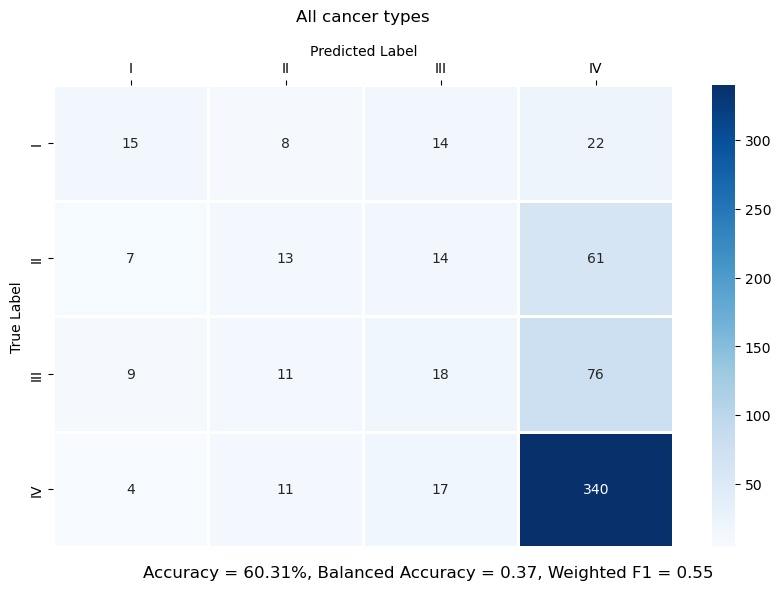

In [12]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
balanced_accuracy = balanced_accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int), average='weighted')
cm = confusion_matrix(y_true, y_pred.astype(int))

title = 'All cancer types'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, Weighted F1 = {f1:.2f}'

filename = f'all_cancer_types.png'
plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_multiclass, filename))

Check model performance for each cancer type separately

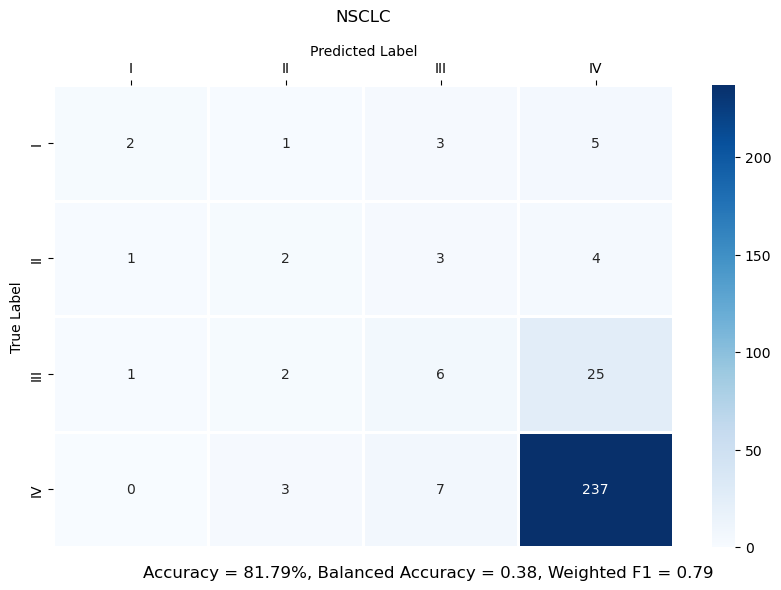

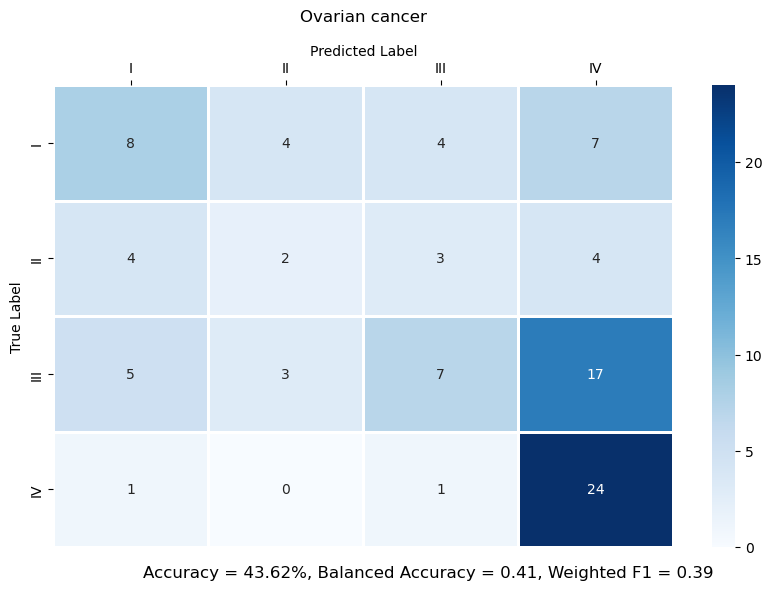

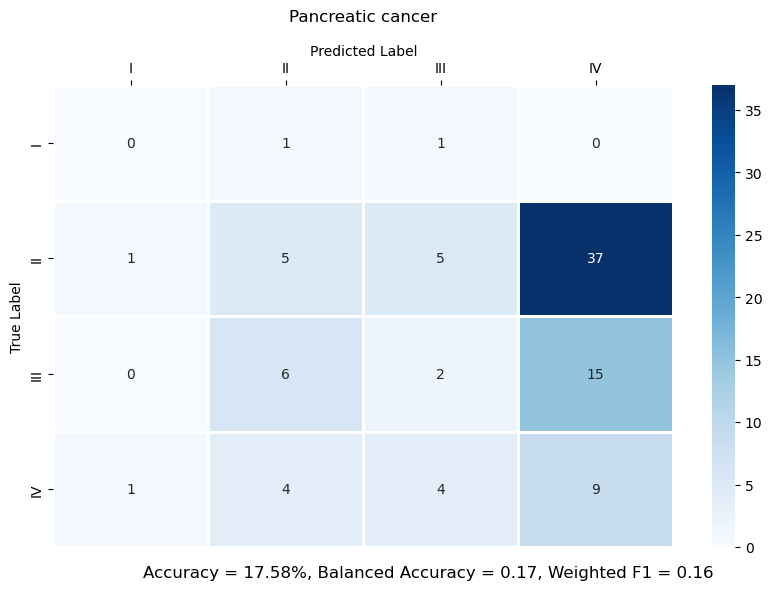

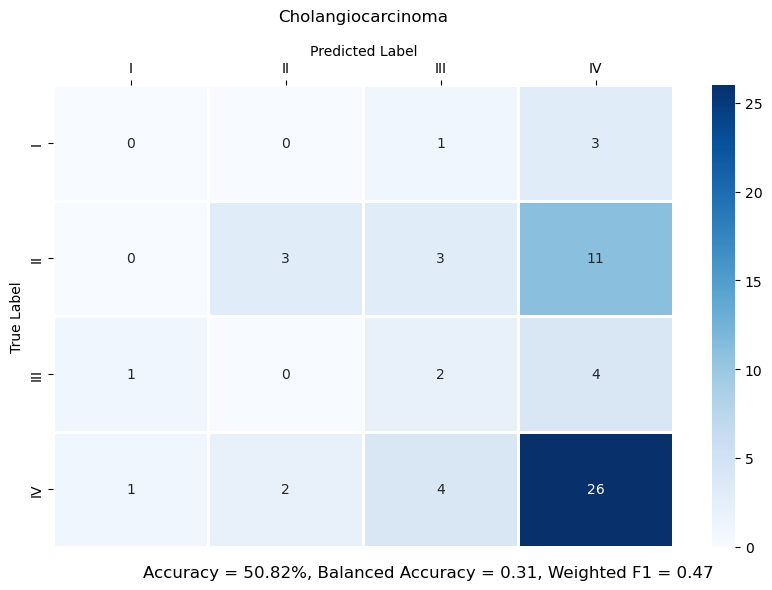

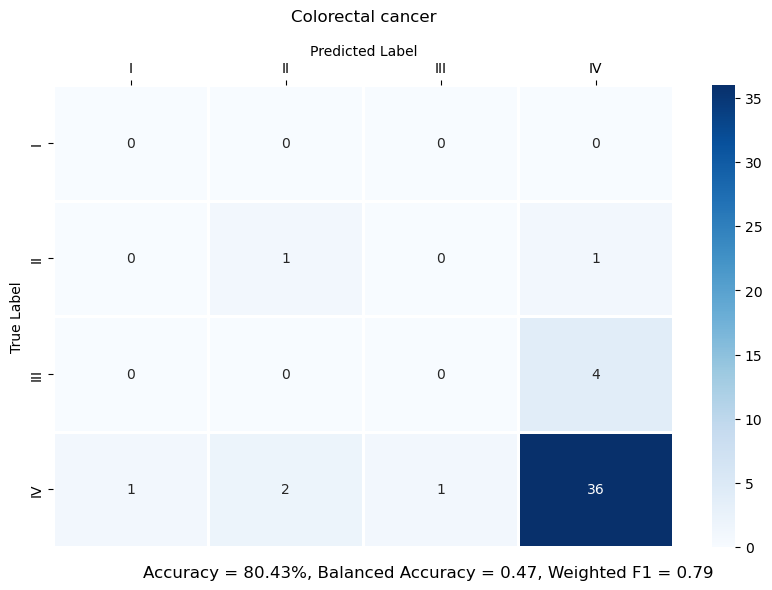

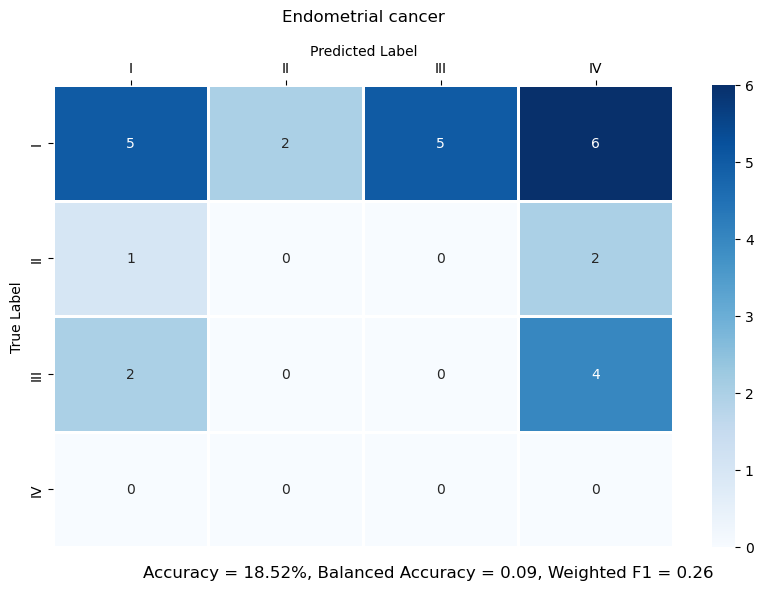

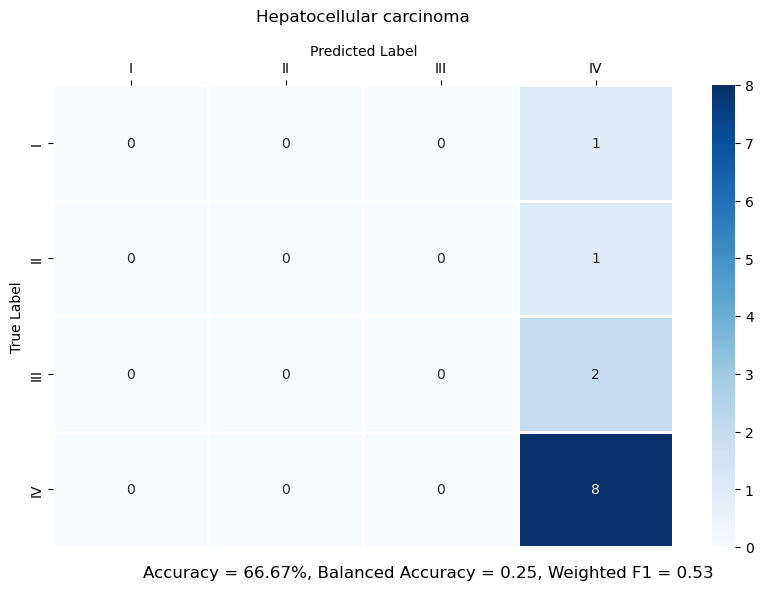

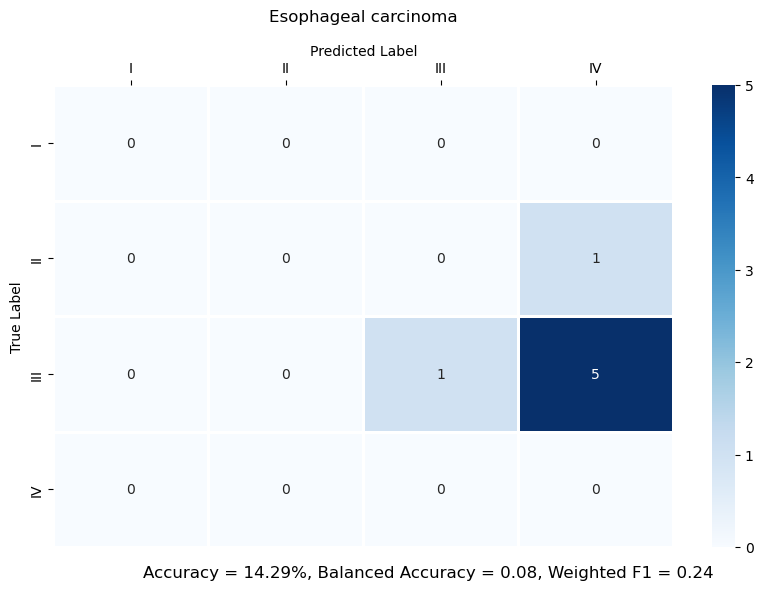

In [14]:
results = pd.DataFrame({
    'group': cancer_types,
    'y_true': y_true,
    'y_pred': y_pred.astype(int)
})

group_names = cancer_types.value_counts().index

for group_name in group_names:
    sub_results = results.loc[results['group'] == group_name]

    accuracy = accuracy_score(sub_results['y_true'], sub_results['y_pred'])
    balanced_accuracy = balanced_accuracy_score(sub_results['y_true'], sub_results['y_pred'])
    f1 = f1_score(sub_results['y_true'], sub_results['y_pred'], average='weighted')
    cm = confusion_matrix(sub_results['y_true'], sub_results['y_pred'], labels=[0, 1, 2, 3])

    title = group_name
    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, Weighted F1 = {f1:.2f}'

    filename = f'all_cancer_types_only_{group_name.lower().replace(" ", "_")}_results.png'
    plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_multiclass, filename))

## All cancer types together, binary classification (stages: I-III vs IV)

Map first three stages to one mutual class "I-III"

Encode labels

In [15]:
X_train = train.copy(deep=True)

mapping = {
    'I': 'I-III',
    'II': 'I-III',
    'III': 'I-III',
    'IV': 'IV'
}
X_train.loc[:, 'Stage'] = X_train['Stage'].map(mapping)

stratification_groups = X_train.apply(lambda row: f"{row['Group'].replace(' ', '_')}_{row['Stage']}", axis=1)
X_train = X_train.loc[:, ~train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

labels_encoding = {
    'I-III': 0,
    'IV': 1
}
X_train.loc[:, 'Stage'] = X_train['Stage'].map(labels_encoding)

X_train['Stage'].value_counts()

1    372
0    268
Name: Stage, dtype: int64

Run hyperparameters optimization

In [16]:
xgb_config = {
    'objective': 'binary:logistic',
    'random_state': random_state,
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
}

objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=balanced_accuracy_score
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-10-19 12:52:43,094] A new study created in memory with name: no-name-909ebfeb-6dab-4c06-b20b-3a93f66995a6
[I 2023-10-19 12:52:58,680] Trial 0 finished with value: 0.6755353758743176 and parameters: {'n_estimators': 107, 'max_depth': 4, 'learning_rate': 0.2743135733850826, 'subsample': 0.9833822643916919, 'colsample_bytree': 0.6719193264853467, 'gamma': 3.229509007717529}. Best is trial 0 with value: 0.6755353758743176.
[I 2023-10-19 12:53:17,796] Trial 1 finished with value: 0.6793475561304618 and parameters: {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.3893060117708157, 'subsample': 0.967481964759562, 'colsample_bytree': 0.7040089751133982, 'gamma': 4.794932287727884}. Best is trial 1 with value: 0.6793475561304618.
[I 2023-10-19 12:53:35,449] Trial 2 finished with value: 0.6777199700153216 and parameters: {'n_estimators': 146, 'max_depth': 5, 'learning_rate': 0.22926147245250725, 'subsample': 0.7351272522176786, 'colsample_bytree': 0.5883734967754033, 'gamma': 3.2

[I 2023-10-19 13:02:21,884] Trial 25 finished with value: 0.7244334274261994 and parameters: {'n_estimators': 133, 'max_depth': 7, 'learning_rate': 0.04973232198590516, 'subsample': 0.8209876692360415, 'colsample_bytree': 0.540058275681279, 'gamma': 2.742751765918324}. Best is trial 21 with value: 0.7258580394282019.
[I 2023-10-19 13:02:49,948] Trial 26 finished with value: 0.7119842440208723 and parameters: {'n_estimators': 135, 'max_depth': 6, 'learning_rate': 0.04913102439103004, 'subsample': 0.853913692825273, 'colsample_bytree': 0.543656282964523, 'gamma': 3.1097121720284355}. Best is trial 21 with value: 0.7258580394282019.
[I 2023-10-19 13:03:17,465] Trial 27 finished with value: 0.697655850113452 and parameters: {'n_estimators': 116, 'max_depth': 8, 'learning_rate': 0.042567331670095514, 'subsample': 0.9491566690527621, 'colsample_bytree': 0.6276375495042443, 'gamma': 3.7690075075524945}. Best is trial 21 with value: 0.7258580394282019.
[I 2023-10-19 13:03:56,130] Trial 28 fini

[I 2023-10-19 13:14:02,698] Trial 50 finished with value: 0.7152994269770314 and parameters: {'n_estimators': 43, 'max_depth': 7, 'learning_rate': 0.1140481186539736, 'subsample': 0.8487929030309052, 'colsample_bytree': 0.5887688581908006, 'gamma': 2.1323447531295194}. Best is trial 28 with value: 0.7273477325052141.
[I 2023-10-19 13:14:27,168] Trial 51 finished with value: 0.7179287790203842 and parameters: {'n_estimators': 69, 'max_depth': 6, 'learning_rate': 0.05592147215397344, 'subsample': 0.9110390253718182, 'colsample_bytree': 0.7340376214054802, 'gamma': 2.833451353462062}. Best is trial 28 with value: 0.7273477325052141.
[I 2023-10-19 13:14:59,977] Trial 52 finished with value: 0.6985573717500758 and parameters: {'n_estimators': 79, 'max_depth': 7, 'learning_rate': 0.029288952878164992, 'subsample': 0.8854941255165378, 'colsample_bytree': 0.6727822160293719, 'gamma': 2.7488918588209046}. Best is trial 28 with value: 0.7273477325052141.
[I 2023-10-19 13:15:13,814] Trial 53 fini

[I 2023-10-19 13:26:10,033] Trial 75 finished with value: 0.7224178674337502 and parameters: {'n_estimators': 119, 'max_depth': 7, 'learning_rate': 0.04566727294065917, 'subsample': 0.7975180684175665, 'colsample_bytree': 0.5157721610176133, 'gamma': 3.574016504973226}. Best is trial 66 with value: 0.7280659983397917.
[I 2023-10-19 13:26:33,453] Trial 76 finished with value: 0.7159952878615277 and parameters: {'n_estimators': 110, 'max_depth': 7, 'learning_rate': 0.06600575867207491, 'subsample': 0.7113232645062894, 'colsample_bytree': 0.5515985880280815, 'gamma': 3.3363028309184264}. Best is trial 66 with value: 0.7280659983397917.
[I 2023-10-19 13:26:59,399] Trial 77 finished with value: 0.6985398276543514 and parameters: {'n_estimators': 146, 'max_depth': 8, 'learning_rate': 0.08224831829298829, 'subsample': 0.7503835405201776, 'colsample_bytree': 0.5802453921558343, 'gamma': 3.7676309208309404}. Best is trial 66 with value: 0.7280659983397917.
[I 2023-10-19 13:27:17,404] Trial 78 f

Extract the best of the found hyperparameters and perform cross validation on the whole training set

In [17]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)

y_true = list(X_train['Stage'].values)
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

       I-III       0.72      0.62      0.67       268
          IV       0.75      0.83      0.79       372

    accuracy                           0.74       640
   macro avg       0.74      0.72      0.73       640
weighted avg       0.74      0.74      0.74       640



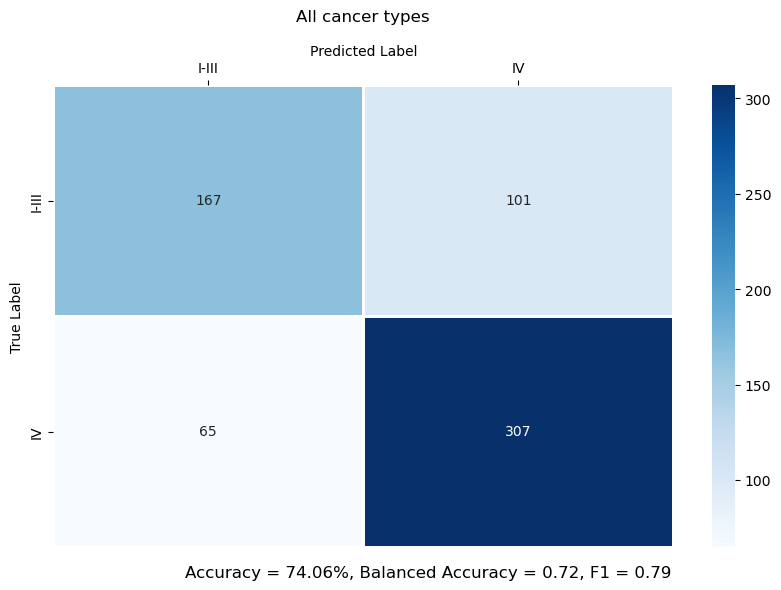

In [18]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
balanced_accuracy = balanced_accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int))
cm = confusion_matrix(y_true, y_pred.astype(int))

title = 'All cancer types'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, F1 = {f1:.2f}'

filename = f'all_cancer_types.png'
plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_binary, filename))

Check model performance for each cancer type separately

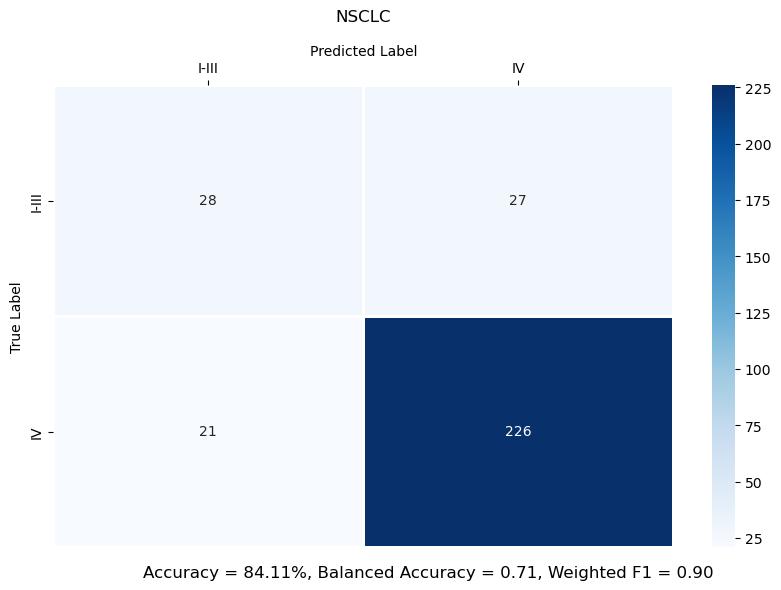

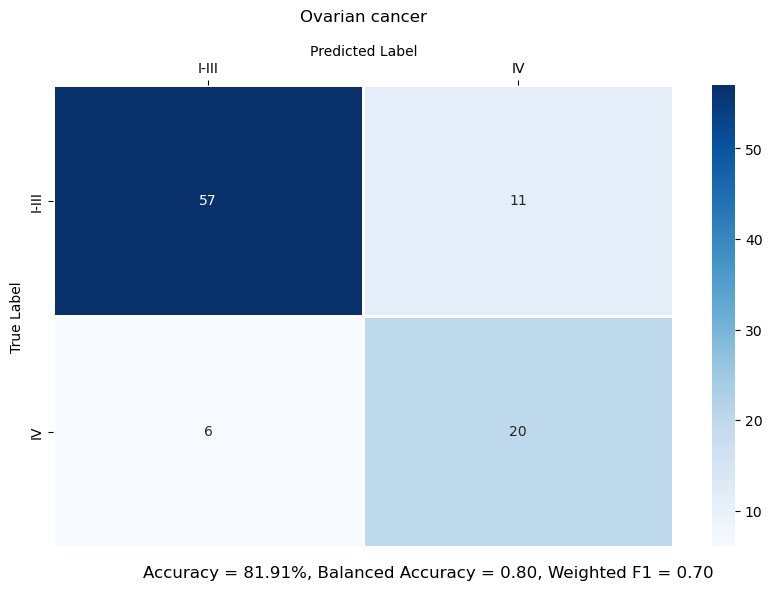

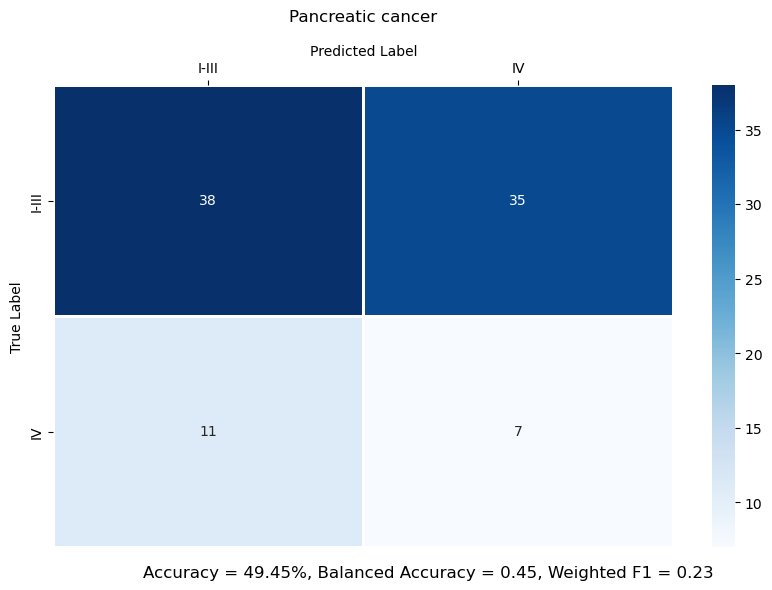

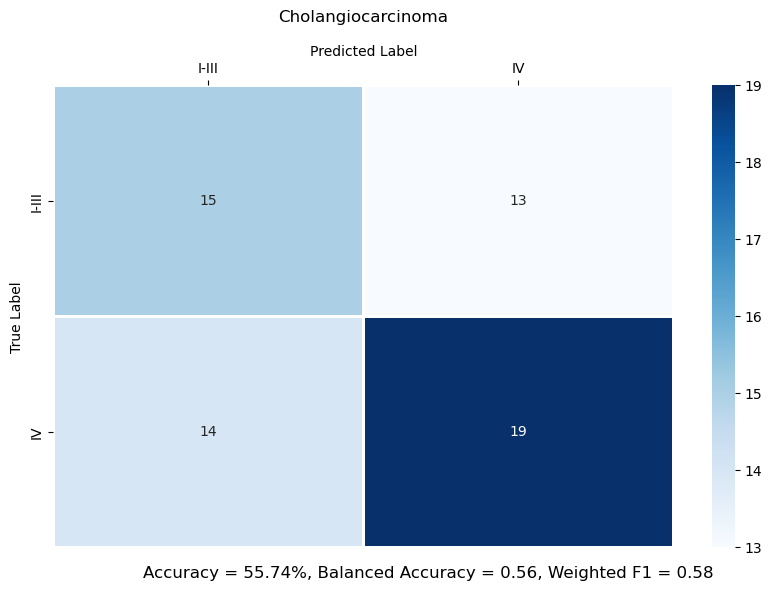

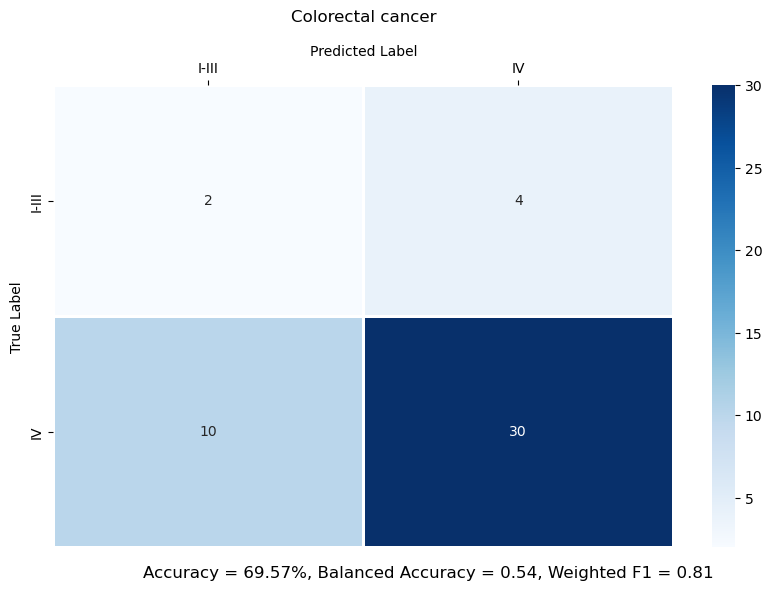

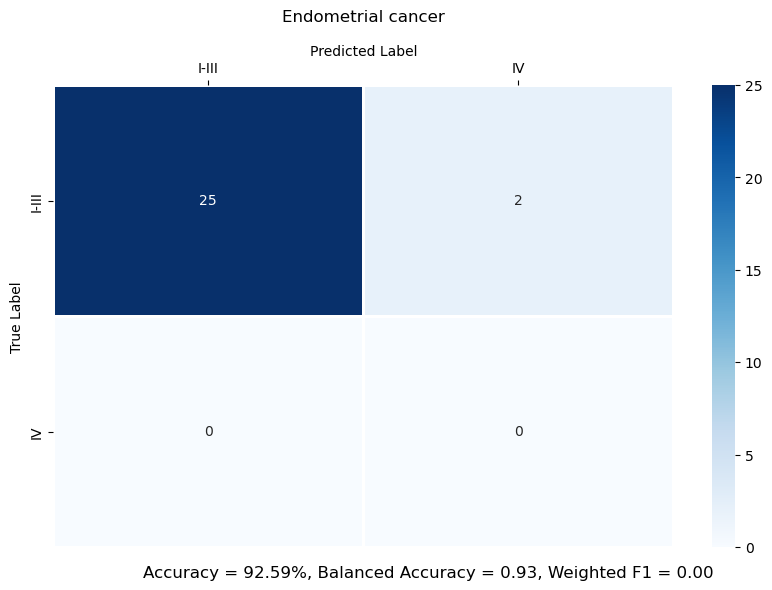

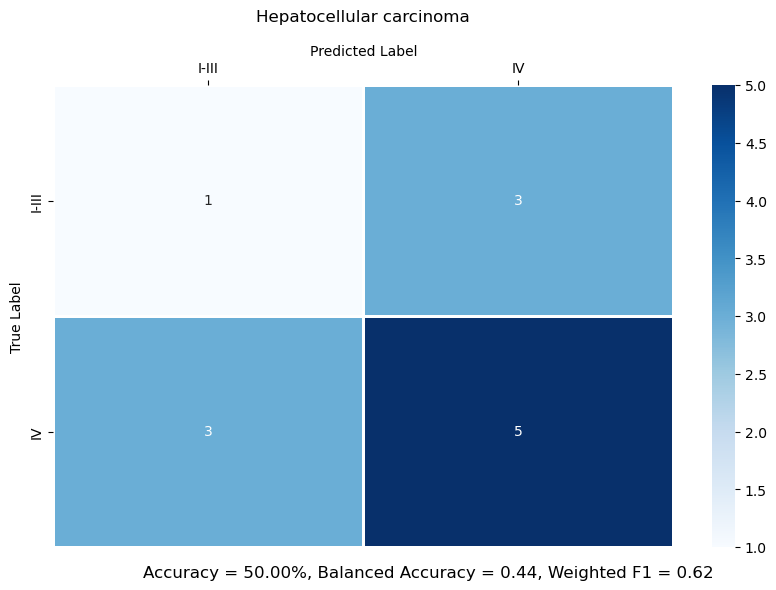

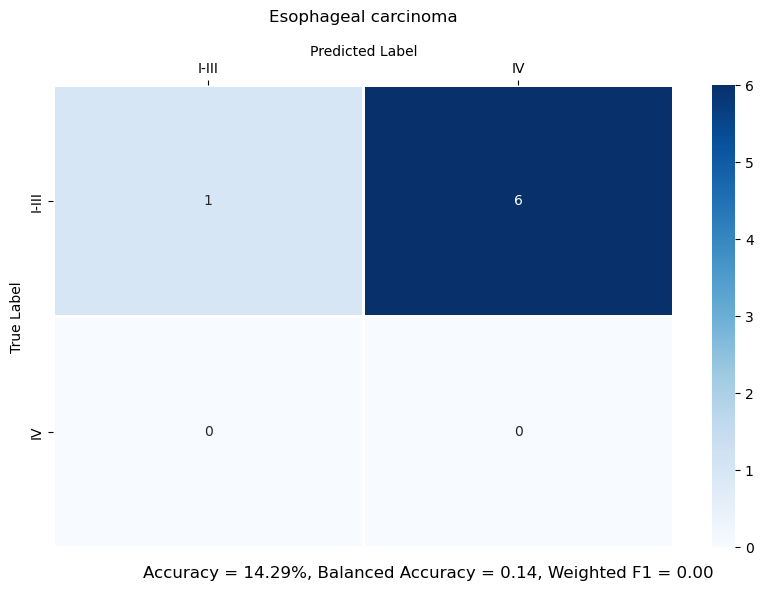

In [19]:
results = pd.DataFrame({
    'group': cancer_types,
    'y_true': y_true,
    'y_pred': y_pred.astype(int)
})

group_names = cancer_types.value_counts().index

for group_name in group_names:
    sub_results = results.loc[results['group'] == group_name]

    accuracy = accuracy_score(sub_results['y_true'], sub_results['y_pred'])
    balanced_accuracy = balanced_accuracy_score(sub_results['y_true'], sub_results['y_pred'])
    f1 = f1_score(sub_results['y_true'], sub_results['y_pred'])
    cm = confusion_matrix(sub_results['y_true'], sub_results['y_pred'], labels=[0, 1])

    title = group_name
    scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, Weighted F1 = {f1:.2f}'

    filename = f'all_cancer_types_only_{group_name.lower().replace(" ", "_")}_results.png'
    plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_binary, filename))

## Only the most numerous types of cancer (each one separately), multiclass classification (stages: I, II, III, IV)

In [20]:
labels_encoding = {
    'I': 0,
    'II': 1,
    'III': 2,
    'IV': 3
}

xgb_config = {
    'objective': 'multi:softmax',
    'random_state': random_state,
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'num_class': 4,
}

scoring_func = balanced_accuracy_score

Get only the most numerous cancer types (with more than 90 cases)

In [21]:
cancer_type_counts = train['Group'].value_counts()
numerous_cancer_types = cancer_type_counts[cancer_type_counts > 90].index.tolist()
numerous_cancer_types

['NSCLC', 'Ovarian cancer', 'Pancreatic cancer']

For each cancer type a separate model will be created, optimized and tested

### NSCLC

In [22]:
X_train = train.loc[train['Group'] == 'NSCLC']

stratification_groups = X_train.loc[:, 'Stage']
X_train = X_train.loc[:, ~X_train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

X_train.loc[:, 'Stage'] = X_train['Stage'].map(labels_encoding)
X_train['Stage'].value_counts()

3    247
2     34
0     11
1     10
Name: Stage, dtype: int64

In [23]:
objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=scoring_func
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-10-19 13:58:26,408] A new study created in memory with name: no-name-bebc02dc-badf-4079-8d70-a8ef9882ed3f
[I 2023-10-19 13:58:45,261] Trial 0 finished with value: 0.25591985428051 and parameters: {'n_estimators': 85, 'max_depth': 4, 'learning_rate': 0.1076801266565525, 'subsample': 0.6377691082099963, 'colsample_bytree': 0.9879550413222817, 'gamma': 3.8591019036204504}. Best is trial 0 with value: 0.25591985428051.
[I 2023-10-19 13:59:07,041] Trial 1 finished with value: 0.2489754098360656 and parameters: {'n_estimators': 66, 'max_depth': 4, 'learning_rate': 0.0426770000834209, 'subsample': 0.706089459228912, 'colsample_bytree': 0.7253773232696634, 'gamma': 2.1385012562620287}. Best is trial 0 with value: 0.25591985428051.
[I 2023-10-19 13:59:23,269] Trial 2 finished with value: 0.2547717808038075 and parameters: {'n_estimators': 84, 'max_depth': 2, 'learning_rate': 0.47381060834081, 'subsample': 0.9377682109685457, 'colsample_bytree': 0.6394482611518831, 'gamma': 3.96034657000

[I 2023-10-19 14:08:30,761] Trial 25 finished with value: 0.25 and parameters: {'n_estimators': 115, 'max_depth': 6, 'learning_rate': 0.2825937088539519, 'subsample': 0.8533608047008032, 'colsample_bytree': 0.5012988646701169, 'gamma': 1.1478806581426686}. Best is trial 16 with value: 0.2925347222222222.
[I 2023-10-19 14:08:52,513] Trial 26 finished with value: 0.2845656876138434 and parameters: {'n_estimators': 104, 'max_depth': 5, 'learning_rate': 0.32589601844048477, 'subsample': 0.9150327719422285, 'colsample_bytree': 0.5453265809033038, 'gamma': 0.37368240355904203}. Best is trial 16 with value: 0.2925347222222222.
[I 2023-10-19 14:09:09,875] Trial 27 finished with value: 0.27473705858158526 and parameters: {'n_estimators': 94, 'max_depth': 3, 'learning_rate': 0.40748658875651284, 'subsample': 0.9620862672782706, 'colsample_bytree': 0.6037777423856034, 'gamma': 0.7915754557450634}. Best is trial 16 with value: 0.2925347222222222.
[I 2023-10-19 14:09:29,942] Trial 28 finished with 

[I 2023-10-19 14:19:28,331] Trial 50 finished with value: 0.27557206284153 and parameters: {'n_estimators': 127, 'max_depth': 2, 'learning_rate': 0.28913074740624367, 'subsample': 0.8394480671882424, 'colsample_bytree': 0.6100238298151054, 'gamma': 0.4511071662529098}. Best is trial 44 with value: 0.3053990209471767.
[I 2023-10-19 14:19:57,901] Trial 51 finished with value: 0.25 and parameters: {'n_estimators': 143, 'max_depth': 4, 'learning_rate': 0.27906136716434793, 'subsample': 0.943729319838059, 'colsample_bytree': 0.503746241072428, 'gamma': 0.07801861575208974}. Best is trial 44 with value: 0.3053990209471767.
[I 2023-10-19 14:20:26,872] Trial 52 finished with value: 0.2906420765027322 and parameters: {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.30604878019592424, 'subsample': 0.9869370187189351, 'colsample_bytree': 0.5124389091269783, 'gamma': 0.040835030786516534}. Best is trial 44 with value: 0.3053990209471767.
[I 2023-10-19 14:20:55,979] Trial 53 finished with v

[I 2023-10-19 14:29:05,073] Trial 75 finished with value: 0.2698087431693989 and parameters: {'n_estimators': 138, 'max_depth': 3, 'learning_rate': 0.24520465176927286, 'subsample': 0.9047100457159544, 'colsample_bytree': 0.5287807748739929, 'gamma': 0.431374397119867}. Best is trial 44 with value: 0.3053990209471767.
[I 2023-10-19 14:29:35,327] Trial 76 finished with value: 0.2767531876138434 and parameters: {'n_estimators': 131, 'max_depth': 5, 'learning_rate': 0.26886910010827564, 'subsample': 0.9640806849661333, 'colsample_bytree': 0.5419005891106473, 'gamma': 0.2902890318834543}. Best is trial 44 with value: 0.3053990209471767.
[I 2023-10-19 14:30:01,997] Trial 77 finished with value: 0.2698087431693989 and parameters: {'n_estimators': 142, 'max_depth': 2, 'learning_rate': 0.2295501187470025, 'subsample': 0.9808361536144582, 'colsample_bytree': 0.5655197022794209, 'gamma': 0.5189562082777304}. Best is trial 44 with value: 0.3053990209471767.
[I 2023-10-19 14:30:11,309] Trial 78 fi

In [24]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)

y_true = list(X_train['Stage'].values)
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

           I       0.25      0.09      0.13        11
          II       0.00      0.00      0.00        10
         III       0.67      0.06      0.11        34
          IV       0.84      1.00      0.91       247

    accuracy                           0.82       302
   macro avg       0.44      0.29      0.29       302
weighted avg       0.77      0.82      0.76       302



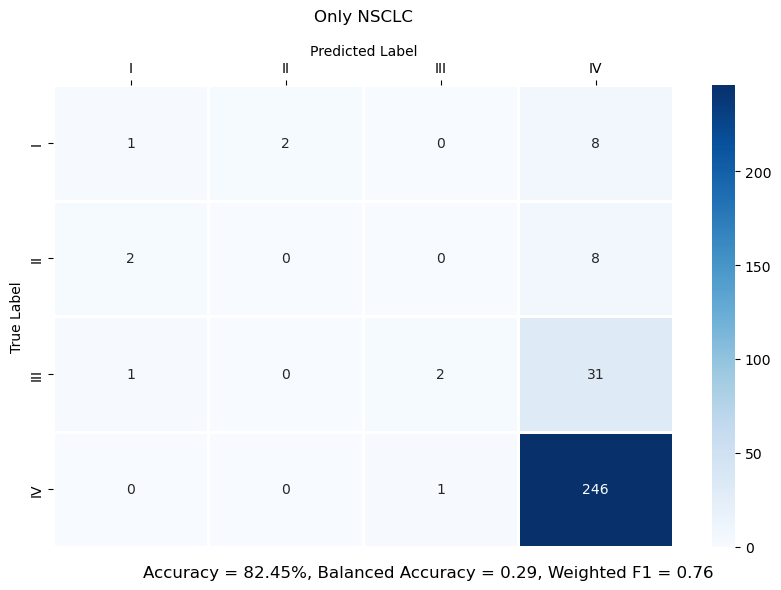

In [25]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
balanced_accuracy = balanced_accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int), average='weighted')
cm = confusion_matrix(y_true, y_pred.astype(int))

title = 'Only NSCLC'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, Weighted F1 = {f1:.2f}'

filename = f'nsclc_only.png'
plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_multiclass, filename))

### Ovarian cancer

In [26]:
X_train = train.loc[train['Group'] == 'Ovarian cancer']

stratification_groups = X_train.loc[:, 'Stage']
X_train = X_train.loc[:, ~X_train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

X_train.loc[:, 'Stage'] = X_train['Stage'].map(labels_encoding)
X_train['Stage'].value_counts()

2    32
3    26
0    23
1    13
Name: Stage, dtype: int64

In [27]:
objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=scoring_func
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-10-19 14:39:36,411] A new study created in memory with name: no-name-01cd3b30-cbb3-4f4f-a017-a1aa4327e481
[I 2023-10-19 14:39:47,888] Trial 0 finished with value: 0.4147321428571429 and parameters: {'n_estimators': 58, 'max_depth': 5, 'learning_rate': 0.0581650176702727, 'subsample': 0.961182084651481, 'colsample_bytree': 0.7420347480477935, 'gamma': 2.412716207543632}. Best is trial 0 with value: 0.4147321428571429.
[I 2023-10-19 14:39:56,240] Trial 1 finished with value: 0.3616815476190476 and parameters: {'n_estimators': 38, 'max_depth': 7, 'learning_rate': 0.40263072099099967, 'subsample': 0.8022059196118319, 'colsample_bytree': 0.6537887950908077, 'gamma': 2.8623292293841307}. Best is trial 0 with value: 0.4147321428571429.
[I 2023-10-19 14:40:07,604] Trial 2 finished with value: 0.3765625 and parameters: {'n_estimators': 61, 'max_depth': 5, 'learning_rate': 0.29540588328155354, 'subsample': 0.9917492921752733, 'colsample_bytree': 0.5738236010442217, 'gamma': 0.44299696537

[I 2023-10-19 14:46:38,782] Trial 25 finished with value: 0.36227678571428573 and parameters: {'n_estimators': 140, 'max_depth': 4, 'learning_rate': 0.034629430663174005, 'subsample': 0.8301127272548561, 'colsample_bytree': 0.755664826509739, 'gamma': 3.023536918028871}. Best is trial 0 with value: 0.4147321428571429.
[I 2023-10-19 14:46:54,911] Trial 26 finished with value: 0.3553571428571428 and parameters: {'n_estimators': 102, 'max_depth': 4, 'learning_rate': 0.1822645602589748, 'subsample': 0.877685649945864, 'colsample_bytree': 0.6753143510044695, 'gamma': 2.424758655583469}. Best is trial 0 with value: 0.4147321428571429.
[I 2023-10-19 14:47:03,608] Trial 27 finished with value: 0.34025297619047623 and parameters: {'n_estimators': 57, 'max_depth': 6, 'learning_rate': 0.13215699068413672, 'subsample': 0.8217253912163613, 'colsample_bytree': 0.8467434893279172, 'gamma': 2.635083857434461}. Best is trial 0 with value: 0.4147321428571429.
[I 2023-10-19 14:47:27,581] Trial 28 finishe

[I 2023-10-19 14:53:33,747] Trial 50 finished with value: 0.3782738095238095 and parameters: {'n_estimators': 42, 'max_depth': 6, 'learning_rate': 0.050116925863320276, 'subsample': 0.9914341071316537, 'colsample_bytree': 0.8683395489660114, 'gamma': 3.222352417565161}. Best is trial 39 with value: 0.4173363095238095.
[I 2023-10-19 14:53:45,764] Trial 51 finished with value: 0.4106398809523809 and parameters: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.10530304826574562, 'subsample': 0.9029164298237718, 'colsample_bytree': 0.8863485942031936, 'gamma': 1.842643690041762}. Best is trial 39 with value: 0.4173363095238095.
[I 2023-10-19 14:53:57,145] Trial 52 finished with value: 0.4158482142857143 and parameters: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.07577906643566516, 'subsample': 0.9289879624262773, 'colsample_bytree': 0.8854879498079594, 'gamma': 1.6773263104759328}. Best is trial 39 with value: 0.4173363095238095.
[I 2023-10-19 14:54:11,298] Trial 53 fini

[I 2023-10-19 14:58:52,559] Trial 75 finished with value: 0.370610119047619 and parameters: {'n_estimators': 80, 'max_depth': 5, 'learning_rate': 0.10010151150916438, 'subsample': 0.9205154261750345, 'colsample_bytree': 0.7746057605118188, 'gamma': 2.4011917920054207}. Best is trial 62 with value: 0.4340773809523809.
[I 2023-10-19 14:59:04,468] Trial 76 finished with value: 0.4106398809523809 and parameters: {'n_estimators': 49, 'max_depth': 4, 'learning_rate': 0.0366448512869871, 'subsample': 0.979731847521237, 'colsample_bytree': 0.810744147586704, 'gamma': 2.226657357234859}. Best is trial 62 with value: 0.4340773809523809.
[I 2023-10-19 14:59:14,028] Trial 77 finished with value: 0.3767857142857143 and parameters: {'n_estimators': 39, 'max_depth': 3, 'learning_rate': 0.017877865833889194, 'subsample': 0.9996376858454885, 'colsample_bytree': 0.7570074944458304, 'gamma': 2.9507144614184706}. Best is trial 62 with value: 0.4340773809523809.
[I 2023-10-19 14:59:28,965] Trial 78 finishe

In [28]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)

y_true = list(X_train['Stage'].values)
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

           I       0.45      0.39      0.42        23
          II       0.00      0.00      0.00        13
         III       0.36      0.53      0.43        32
          IV       0.76      0.73      0.75        26

    accuracy                           0.48        94
   macro avg       0.39      0.41      0.40        94
weighted avg       0.44      0.48      0.46        94



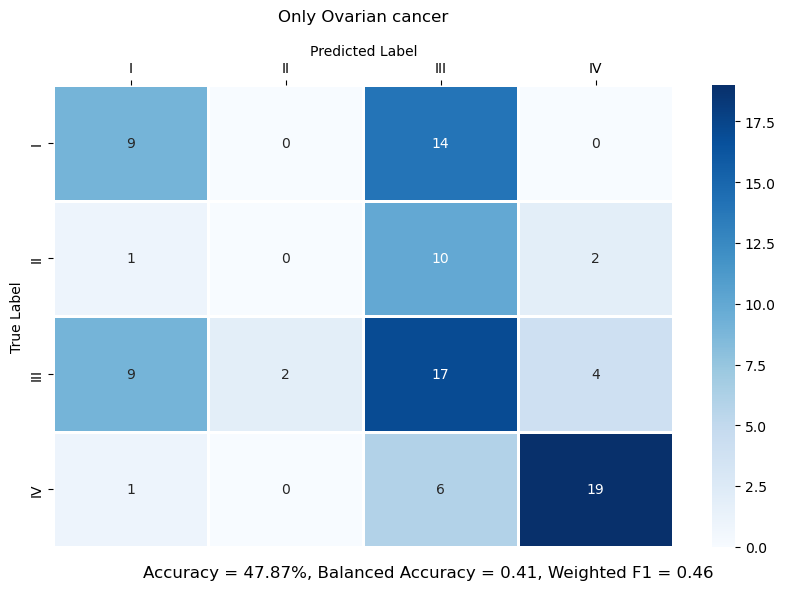

In [29]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
balanced_accuracy = balanced_accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int), average='weighted')
cm = confusion_matrix(y_true, y_pred.astype(int))

title = 'Only Ovarian cancer'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, Weighted F1 = {f1:.2f}'

filename = f'ovarian_cancer_only.png'
plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_multiclass, filename))

### Pancreatic cancer


In [30]:
X_train = train.loc[train['Group'] == 'Pancreatic cancer']

stratification_groups = X_train.loc[:, 'Stage']
X_train = X_train.loc[:, ~X_train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

X_train.loc[:, 'Stage'] = X_train['Stage'].map(labels_encoding)
X_train['Stage'].value_counts()

1    48
2    23
3    18
0     2
Name: Stage, dtype: int64

In [31]:
objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=scoring_func
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-10-19 15:04:00,606] A new study created in memory with name: no-name-328470c2-a1e4-4f2b-94b2-a74ca9797261
[I 2023-10-19 15:04:18,588] Trial 0 finished with value: 0.3555555555555555 and parameters: {'n_estimators': 104, 'max_depth': 3, 'learning_rate': 0.0856130830856279, 'subsample': 0.6632064031069568, 'colsample_bytree': 0.6602678883900233, 'gamma': 0.6949533550199372}. Best is trial 0 with value: 0.3555555555555555.
[I 2023-10-19 15:04:35,045] Trial 1 finished with value: 0.3881944444444444 and parameters: {'n_estimators': 96, 'max_depth': 5, 'learning_rate': 0.469749639202611, 'subsample': 0.6513120799347196, 'colsample_bytree': 0.7746783176608998, 'gamma': 3.0860302380803146}. Best is trial 1 with value: 0.3881944444444444.
[I 2023-10-19 15:04:50,757] Trial 2 finished with value: 0.32048611111111114 and parameters: {'n_estimators': 82, 'max_depth': 4, 'learning_rate': 0.2092963000700221, 'subsample': 0.8467570059087903, 'colsample_bytree': 0.9493858601209479, 'gamma': 3.1

[I 2023-10-19 15:10:32,016] Trial 25 finished with value: 0.30694444444444446 and parameters: {'n_estimators': 89, 'max_depth': 5, 'learning_rate': 0.3088700101552844, 'subsample': 0.7307554140058063, 'colsample_bytree': 0.7290174515848032, 'gamma': 2.8374473968968696}. Best is trial 21 with value: 0.4222222222222222.
[I 2023-10-19 15:10:40,072] Trial 26 finished with value: 0.3375 and parameters: {'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.40686856267109794, 'subsample': 0.6680897895760418, 'colsample_bytree': 0.8167317713510543, 'gamma': 4.948954667817933}. Best is trial 21 with value: 0.4222222222222222.
[I 2023-10-19 15:10:59,697] Trial 27 finished with value: 0.2791666666666667 and parameters: {'n_estimators': 135, 'max_depth': 6, 'learning_rate': 0.35350115931864623, 'subsample': 0.5789285964486244, 'colsample_bytree': 0.7816521529739626, 'gamma': 2.172091562433497}. Best is trial 21 with value: 0.4222222222222222.
[I 2023-10-19 15:11:19,571] Trial 28 finished with va

[I 2023-10-19 15:17:38,664] Trial 50 finished with value: 0.32326388888888885 and parameters: {'n_estimators': 106, 'max_depth': 6, 'learning_rate': 0.47946036489225025, 'subsample': 0.6823427528093303, 'colsample_bytree': 0.6841557068816848, 'gamma': 3.8128652248457393}. Best is trial 21 with value: 0.4222222222222222.
[I 2023-10-19 15:17:54,588] Trial 51 finished with value: 0.39340277777777777 and parameters: {'n_estimators': 118, 'max_depth': 4, 'learning_rate': 0.24472101215812259, 'subsample': 0.6742553097973841, 'colsample_bytree': 0.7052937536754738, 'gamma': 4.023789176683576}. Best is trial 21 with value: 0.4222222222222222.
[I 2023-10-19 15:18:12,953] Trial 52 finished with value: 0.3486111111111111 and parameters: {'n_estimators': 118, 'max_depth': 4, 'learning_rate': 0.24783421039621018, 'subsample': 0.6431016013937529, 'colsample_bytree': 0.7021792451813437, 'gamma': 4.176569652223015}. Best is trial 21 with value: 0.4222222222222222.
[I 2023-10-19 15:18:31,402] Trial 53 

[I 2023-10-19 15:24:44,987] Trial 75 finished with value: 0.3295138888888889 and parameters: {'n_estimators': 112, 'max_depth': 4, 'learning_rate': 0.3515516621492315, 'subsample': 0.6798069111931576, 'colsample_bytree': 0.6761905092518782, 'gamma': 3.657214013281032}. Best is trial 72 with value: 0.4371527777777777.
[I 2023-10-19 15:25:03,569] Trial 76 finished with value: 0.36006944444444444 and parameters: {'n_estimators': 143, 'max_depth': 5, 'learning_rate': 0.4071708092505652, 'subsample': 0.7010572052293323, 'colsample_bytree': 0.7795532324538537, 'gamma': 4.0700941077435475}. Best is trial 72 with value: 0.4371527777777777.
[I 2023-10-19 15:25:19,860] Trial 77 finished with value: 0.3427083333333333 and parameters: {'n_estimators': 120, 'max_depth': 4, 'learning_rate': 0.3036792780189296, 'subsample': 0.637908292722742, 'colsample_bytree': 0.7184718923410158, 'gamma': 3.8147407293676214}. Best is trial 72 with value: 0.4371527777777777.
[I 2023-10-19 15:25:36,442] Trial 78 fini

In [32]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)

y_true = list(X_train['Stage'].values)
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

           I       0.00      0.00      0.00         2
          II       0.52      0.73      0.61        48
         III       0.21      0.13      0.16        23
          IV       0.40      0.22      0.29        18

    accuracy                           0.46        91
   macro avg       0.28      0.27      0.26        91
weighted avg       0.41      0.46      0.42        91



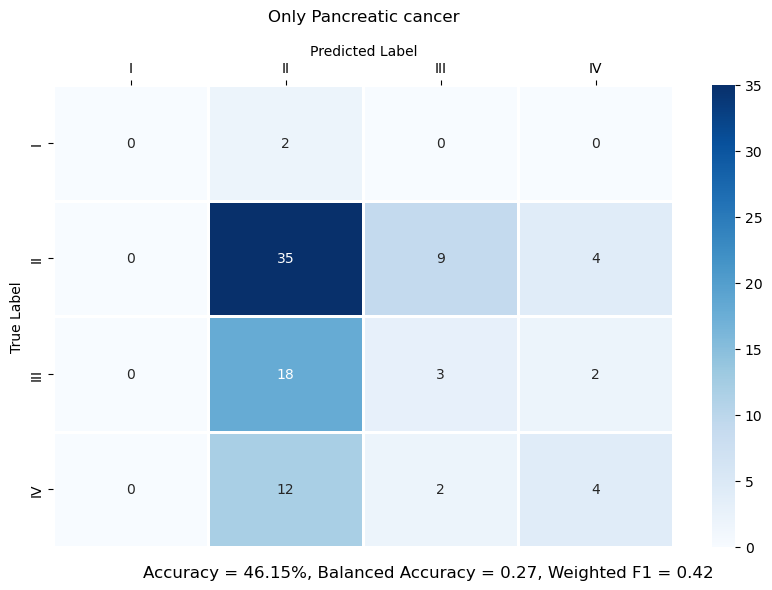

In [33]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
balanced_accuracy = balanced_accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int), average='weighted')
cm = confusion_matrix(y_true, y_pred.astype(int))

title = 'Only Pancreatic cancer'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, Weighted F1 = {f1:.2f}'

filename = f'pancreatic_cancer_only.png'
plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_multiclass, filename))

## Only the most numerous types of cancer (each one separately), binary classification (stages: I-III vs IV)

In [34]:
mapping = {
    'I': 'I-III',
    'II': 'I-III',
    'III': 'I-III',
    'IV': 'IV'
}

labels_encoding = {
    'I-III': 0,
    'IV': 1
}

xgb_config = {
    'objective': 'binary:logistic',
    'random_state': random_state,
    'tree_method': 'gpu_hist',
    'gpu_id': 0
}

### NSCLC

In [35]:
X_train = train.loc[train['Group'] == 'NSCLC']

stratification_groups = X_train.loc[:, 'Stage']
X_train = X_train.loc[:, ~X_train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

X_train.loc[:, 'Stage'] = X_train['Stage'].map(mapping).map(labels_encoding)
X_train['Stage'].value_counts()

1    247
0     55
Name: Stage, dtype: int64

In [36]:
objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=balanced_accuracy_score
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-10-19 15:32:16,059] A new study created in memory with name: no-name-7c6068d7-b2cd-480d-912d-96fb3f4942f2
[I 2023-10-19 15:32:24,633] Trial 0 finished with value: 0.5828364985094229 and parameters: {'n_estimators': 41, 'max_depth': 3, 'learning_rate': 0.013994114304033373, 'subsample': 0.7177831514265443, 'colsample_bytree': 0.6473291202852859, 'gamma': 0.22248697112796312}. Best is trial 0 with value: 0.5828364985094229.
[I 2023-10-19 15:32:33,817] Trial 1 finished with value: 0.5960330939112006 and parameters: {'n_estimators': 37, 'max_depth': 4, 'learning_rate': 0.03605739028082114, 'subsample': 0.7814835959971673, 'colsample_bytree': 0.8218854228186799, 'gamma': 4.543200060061651}. Best is trial 1 with value: 0.5960330939112006.
[I 2023-10-19 15:32:40,564] Trial 2 finished with value: 0.5471251668303493 and parameters: {'n_estimators': 26, 'max_depth': 5, 'learning_rate': 0.10228419698632331, 'subsample': 0.560120429260023, 'colsample_bytree': 0.5534075890078023, 'gamma': 4

[I 2023-10-19 15:36:52,533] Trial 25 finished with value: 0.6339466588408946 and parameters: {'n_estimators': 69, 'max_depth': 8, 'learning_rate': 0.4439693977409843, 'subsample': 0.9687098413005863, 'colsample_bytree': 0.7976877795779638, 'gamma': 0.009381064979951836}. Best is trial 5 with value: 0.6525544898429616.
[I 2023-10-19 15:37:00,910] Trial 26 finished with value: 0.6386380299587597 and parameters: {'n_estimators': 90, 'max_depth': 5, 'learning_rate': 0.49853444585054385, 'subsample': 0.8997859380258522, 'colsample_bytree': 0.8653257658018833, 'gamma': 0.45362385507953906}. Best is trial 5 with value: 0.6525544898429616.
[I 2023-10-19 15:37:10,032] Trial 27 finished with value: 0.641578965719632 and parameters: {'n_estimators': 106, 'max_depth': 7, 'learning_rate': 0.3948486489208775, 'subsample': 0.9733927837828839, 'colsample_bytree': 0.7611323754762059, 'gamma': 1.0153151495667188}. Best is trial 5 with value: 0.6525544898429616.
[I 2023-10-19 15:37:20,360] Trial 28 finis

[I 2023-10-19 15:39:41,862] Trial 50 finished with value: 0.6229434345841008 and parameters: {'n_estimators': 44, 'max_depth': 5, 'learning_rate': 0.40459181007420836, 'subsample': 0.9096469384211475, 'colsample_bytree': 0.8063954398191759, 'gamma': 0.29840351220664074}. Best is trial 36 with value: 0.6992269628837582.
[I 2023-10-19 15:39:47,519] Trial 51 finished with value: 0.6312106653262126 and parameters: {'n_estimators': 25, 'max_depth': 7, 'learning_rate': 0.4388460560436874, 'subsample': 0.8818163529581099, 'colsample_bytree': 0.7253069982922835, 'gamma': 0.2593837960911288}. Best is trial 36 with value: 0.6992269628837582.
[I 2023-10-19 15:39:52,943] Trial 52 finished with value: 0.6318974785130258 and parameters: {'n_estimators': 27, 'max_depth': 7, 'learning_rate': 0.4504559545481979, 'subsample': 0.8681422641571233, 'colsample_bytree': 0.6842604499941018, 'gamma': 0.40479006974283066}. Best is trial 36 with value: 0.6992269628837582.
[I 2023-10-19 15:39:58,664] Trial 53 fin

[I 2023-10-19 15:42:33,243] Trial 75 finished with value: 0.627964374335342 and parameters: {'n_estimators': 93, 'max_depth': 5, 'learning_rate': 0.37544105570751485, 'subsample': 0.9110202794725385, 'colsample_bytree': 0.8689823198527393, 'gamma': 1.4903951657555878}. Best is trial 36 with value: 0.6992269628837582.
[I 2023-10-19 15:42:42,282] Trial 76 finished with value: 0.6281916413394467 and parameters: {'n_estimators': 98, 'max_depth': 6, 'learning_rate': 0.4599814558032168, 'subsample': 0.842207461854995, 'colsample_bytree': 0.8531403593482841, 'gamma': 0.15294241806128345}. Best is trial 36 with value: 0.6992269628837582.
[I 2023-10-19 15:42:47,436] Trial 77 finished with value: 0.6230545741056053 and parameters: {'n_estimators': 31, 'max_depth': 2, 'learning_rate': 0.39545406248923903, 'subsample': 0.8089855078953342, 'colsample_bytree': 0.8193620121635798, 'gamma': 2.0580088124798843}. Best is trial 36 with value: 0.6992269628837582.
[I 2023-10-19 15:42:52,987] Trial 78 finis

In [37]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)

y_true = list(X_train['Stage'].values)
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

       I-III       0.80      0.22      0.34        55
          IV       0.85      0.99      0.91       247

    accuracy                           0.85       302
   macro avg       0.83      0.60      0.63       302
weighted avg       0.84      0.85      0.81       302



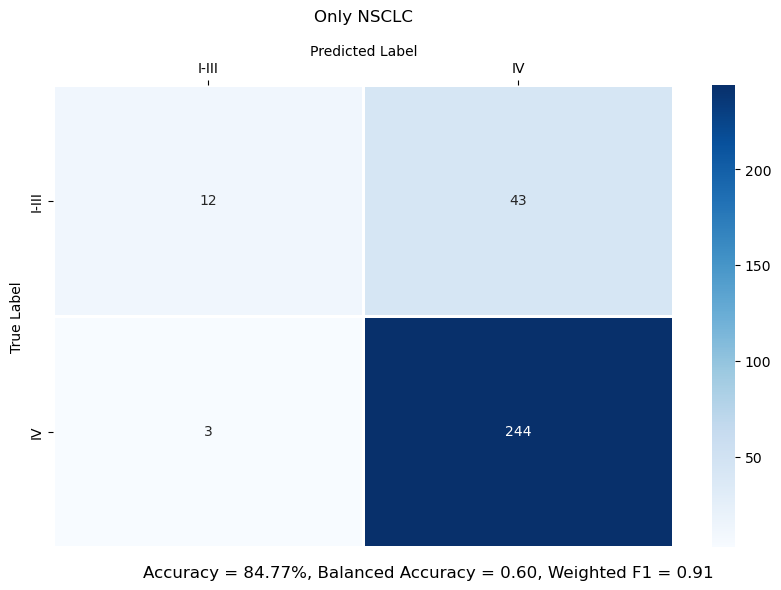

In [38]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
balanced_accuracy = balanced_accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int))
cm = confusion_matrix(y_true, y_pred.astype(int))

title = 'Only NSCLC'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, Weighted F1 = {f1:.2f}'

filename = f'nsclc_only.png'
plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_binary, filename))

### Ovarian cancer

In [39]:
X_train = train.loc[train['Group'] == 'Ovarian cancer']

stratification_groups = X_train.loc[:, 'Stage']
X_train = X_train.loc[:, ~X_train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

X_train.loc[:, 'Stage'] = X_train['Stage'].map(mapping).map(labels_encoding)
X_train['Stage'].value_counts()

0    68
1    26
Name: Stage, dtype: int64

In [40]:
objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=balanced_accuracy_score
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-10-19 15:45:12,748] A new study created in memory with name: no-name-814fb0e7-143f-4c60-9a27-0110ef240abb
[I 2023-10-19 15:45:17,326] Trial 0 finished with value: 0.7266646241830065 and parameters: {'n_estimators': 27, 'max_depth': 8, 'learning_rate': 0.31732345521601535, 'subsample': 0.9029255981866429, 'colsample_bytree': 0.9448846871539011, 'gamma': 0.3077635112158633}. Best is trial 0 with value: 0.7266646241830065.
[I 2023-10-19 15:45:27,044] Trial 1 finished with value: 0.7413705065359476 and parameters: {'n_estimators': 101, 'max_depth': 7, 'learning_rate': 0.029777541963329393, 'subsample': 0.9337235473378092, 'colsample_bytree': 0.754813277354474, 'gamma': 2.291680922901089}. Best is trial 1 with value: 0.7413705065359476.
[I 2023-10-19 15:45:33,253] Trial 2 finished with value: 0.7488985177404295 and parameters: {'n_estimators': 49, 'max_depth': 6, 'learning_rate': 0.212898963209513, 'subsample': 0.8996654817380852, 'colsample_bytree': 0.8330575010073284, 'gamma': 0.5

[I 2023-10-19 15:48:06,479] Trial 25 finished with value: 0.8382936507936508 and parameters: {'n_estimators': 35, 'max_depth': 3, 'learning_rate': 0.00721242252061503, 'subsample': 0.6471767319646414, 'colsample_bytree': 0.7167294792259234, 'gamma': 4.317264820875761}. Best is trial 4 with value: 0.8413938492063492.
[I 2023-10-19 15:48:11,921] Trial 26 finished with value: 0.727890114379085 and parameters: {'n_estimators': 42, 'max_depth': 4, 'learning_rate': 0.08362064714595081, 'subsample': 0.6991184333591118, 'colsample_bytree': 0.7126231945098738, 'gamma': 4.464344443107899}. Best is trial 4 with value: 0.8413938492063492.
[I 2023-10-19 15:48:18,655] Trial 27 finished with value: 0.820436507936508 and parameters: {'n_estimators': 55, 'max_depth': 3, 'learning_rate': 0.00425428046131948, 'subsample': 0.6286297299228576, 'colsample_bytree': 0.6207480292013015, 'gamma': 4.056401203922082}. Best is trial 4 with value: 0.8413938492063492.
[I 2023-10-19 15:48:23,778] Trial 28 finished wi

[I 2023-10-19 15:50:49,560] Trial 50 finished with value: 0.7665805905695612 and parameters: {'n_estimators': 145, 'max_depth': 5, 'learning_rate': 0.02003893104780656, 'subsample': 0.7783855465023072, 'colsample_bytree': 0.6799529677309627, 'gamma': 4.2114277580172965}. Best is trial 28 with value: 0.8561507936507936.
[I 2023-10-19 15:50:55,306] Trial 51 finished with value: 0.8413938492063492 and parameters: {'n_estimators': 39, 'max_depth': 3, 'learning_rate': 0.0019231133435268538, 'subsample': 0.8142986680344926, 'colsample_bytree': 0.7272420519135917, 'gamma': 4.443486404940463}. Best is trial 28 with value: 0.8561507936507936.
[I 2023-10-19 15:51:01,386] Trial 52 finished with value: 0.8413938492063492 and parameters: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.003313240587128238, 'subsample': 0.8288977613888676, 'colsample_bytree': 0.7663155574312698, 'gamma': 4.428003969957459}. Best is trial 28 with value: 0.8561507936507936.
[I 2023-10-19 15:51:06,963] Trial 53 f

[I 2023-10-19 15:54:28,355] Trial 75 finished with value: 0.7665805905695612 and parameters: {'n_estimators': 110, 'max_depth': 6, 'learning_rate': 0.032948396738532726, 'subsample': 0.8722036935846158, 'colsample_bytree': 0.6352257052835769, 'gamma': 3.8557104303837377}. Best is trial 28 with value: 0.8561507936507936.
[I 2023-10-19 15:54:39,145] Trial 76 finished with value: 0.7665805905695612 and parameters: {'n_estimators': 125, 'max_depth': 7, 'learning_rate': 0.055926156002481, 'subsample': 0.8208876023898999, 'colsample_bytree': 0.6879583400291586, 'gamma': 4.7218594145449915}. Best is trial 28 with value: 0.8561507936507936.
[I 2023-10-19 15:54:50,182] Trial 77 finished with value: 0.792250233426704 and parameters: {'n_estimators': 113, 'max_depth': 6, 'learning_rate': 0.01412654151701069, 'subsample': 0.8002140116526277, 'colsample_bytree': 0.6675863827994234, 'gamma': 4.51626853096578}. Best is trial 28 with value: 0.8561507936507936.
[I 2023-10-19 15:54:59,642] Trial 78 fini

In [41]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)

y_true = list(X_train['Stage'].values)
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

       I-III       0.90      0.96      0.93        68
          IV       0.86      0.73      0.79        26

    accuracy                           0.89        94
   macro avg       0.88      0.84      0.86        94
weighted avg       0.89      0.89      0.89        94



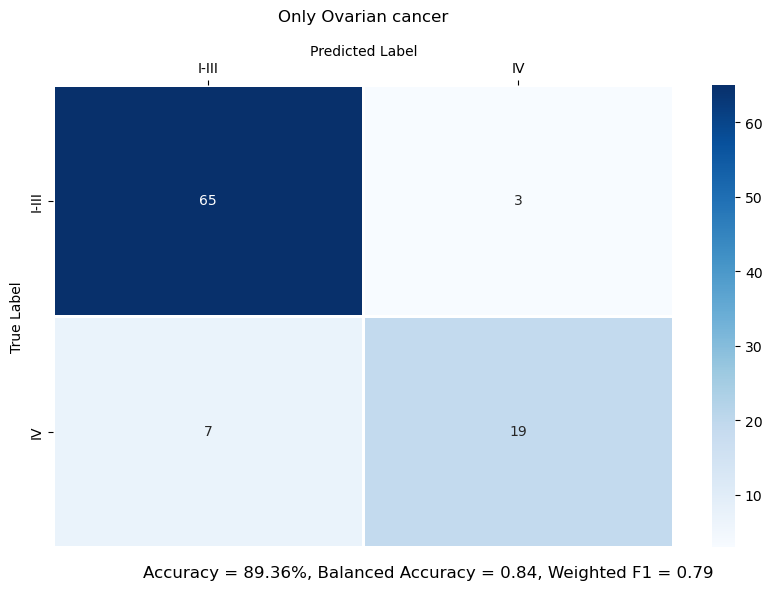

In [42]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
balanced_accuracy = balanced_accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int))
cm = confusion_matrix(y_true, y_pred.astype(int))

title = 'Only Ovarian cancer'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, Weighted F1 = {f1:.2f}'

filename = f'ovarian_cancer_only.png'
plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_binary, filename))

### Pancreatic cancer

In [43]:
X_train = train.loc[train['Group'] == 'Pancreatic cancer']

stratification_groups = X_train.loc[:, 'Stage']
X_train = X_train.loc[:, ~X_train.columns.isin(['ID', 'Sex', 'Age', 'Group'])]

X_train.loc[:, 'Stage'] = X_train['Stage'].map(mapping).map(labels_encoding)
X_train['Stage'].value_counts()

0    73
1    18
Name: Stage, dtype: int64

In [44]:
objective_func = partial(
    objective,
    X_train=X_train,
    stratification_groups=stratification_groups,
    xgb_config=xgb_config,
    scoring=balanced_accuracy_score
)

study = optuna.create_study(direction='maximize')
study.optimize(objective_func, n_trials=100)

[I 2023-10-19 15:59:08,245] A new study created in memory with name: no-name-dafc3bd7-a62d-48e5-b8ca-76b7d8bad999
[I 2023-10-19 15:59:15,430] Trial 0 finished with value: 0.5 and parameters: {'n_estimators': 74, 'max_depth': 2, 'learning_rate': 0.18391414007072618, 'subsample': 0.6084851550974537, 'colsample_bytree': 0.574413731953775, 'gamma': 0.3802646674189175}. Best is trial 0 with value: 0.5.
[I 2023-10-19 15:59:26,890] Trial 1 finished with value: 0.5477941176470589 and parameters: {'n_estimators': 143, 'max_depth': 8, 'learning_rate': 0.37783307582241954, 'subsample': 0.7772930630558283, 'colsample_bytree': 0.9799913630055077, 'gamma': 0.4416218066243216}. Best is trial 1 with value: 0.5477941176470589.
[I 2023-10-19 15:59:33,404] Trial 2 finished with value: 0.5602941176470588 and parameters: {'n_estimators': 58, 'max_depth': 8, 'learning_rate': 0.21025801488796428, 'subsample': 0.8703527445558492, 'colsample_bytree': 0.540771975920919, 'gamma': 2.8143732191310544}. Best is tri

[I 2023-10-19 16:02:49,919] Trial 25 finished with value: 0.5743055555555555 and parameters: {'n_estimators': 108, 'max_depth': 3, 'learning_rate': 0.32199045616780564, 'subsample': 0.8992859557127166, 'colsample_bytree': 0.9472055210090341, 'gamma': 0.6145315818282308}. Best is trial 21 with value: 0.6095996732026143.
[I 2023-10-19 16:03:00,945] Trial 26 finished with value: 0.6412151702786377 and parameters: {'n_estimators': 134, 'max_depth': 5, 'learning_rate': 0.4579552449320804, 'subsample': 0.8463941231346694, 'colsample_bytree': 0.9085727020573333, 'gamma': 0.7324375596699032}. Best is trial 26 with value: 0.6412151702786377.
[I 2023-10-19 16:03:12,094] Trial 27 finished with value: 0.5287581699346404 and parameters: {'n_estimators': 139, 'max_depth': 2, 'learning_rate': 0.3783429178270307, 'subsample': 0.9411791110878708, 'colsample_bytree': 0.9963186547141796, 'gamma': 0.5720362906726536}. Best is trial 26 with value: 0.6412151702786377.
[I 2023-10-19 16:03:17,875] Trial 28 fi

[I 2023-10-19 16:05:48,590] Trial 50 finished with value: 0.5280207258341933 and parameters: {'n_estimators': 70, 'max_depth': 3, 'learning_rate': 0.4405463187145701, 'subsample': 0.7854147730914013, 'colsample_bytree': 0.9821903505829044, 'gamma': 1.045262916256209}. Best is trial 26 with value: 0.6412151702786377.
[I 2023-10-19 16:05:53,741] Trial 51 finished with value: 0.5493055555555556 and parameters: {'n_estimators': 33, 'max_depth': 7, 'learning_rate': 0.4148091087930318, 'subsample': 0.8807109409472021, 'colsample_bytree': 0.9354468660128354, 'gamma': 1.2543174323150774}. Best is trial 26 with value: 0.6412151702786377.
[I 2023-10-19 16:05:59,600] Trial 52 finished with value: 0.5475447196422428 and parameters: {'n_estimators': 45, 'max_depth': 6, 'learning_rate': 0.4582635218628044, 'subsample': 0.910367200465112, 'colsample_bytree': 0.908332744385101, 'gamma': 0.967839246939943}. Best is trial 26 with value: 0.6412151702786377.
[I 2023-10-19 16:06:05,431] Trial 53 finished w

[I 2023-10-19 16:09:29,508] Trial 75 finished with value: 0.5291236670106638 and parameters: {'n_estimators': 125, 'max_depth': 4, 'learning_rate': 0.4474096671144124, 'subsample': 0.7725887753267207, 'colsample_bytree': 0.8330004903916707, 'gamma': 0.39544561873010853}. Best is trial 26 with value: 0.6412151702786377.
[I 2023-10-19 16:09:41,247] Trial 76 finished with value: 0.5214417784657722 and parameters: {'n_estimators': 143, 'max_depth': 5, 'learning_rate': 0.46016982991476985, 'subsample': 0.8144274004863441, 'colsample_bytree': 0.9050064624022435, 'gamma': 0.8650157615433265}. Best is trial 26 with value: 0.6412151702786377.
[I 2023-10-19 16:09:50,686] Trial 77 finished with value: 0.6100447196422428 and parameters: {'n_estimators': 106, 'max_depth': 4, 'learning_rate': 0.48979409031819704, 'subsample': 0.7939129367023923, 'colsample_bytree': 0.8828784141049636, 'gamma': 0.13905938693371922}. Best is trial 26 with value: 0.6412151702786377.
[I 2023-10-19 16:10:00,376] Trial 78

In [45]:
best_params = {
    **study.best_params,
    **xgb_config
}

best_xgb = XGBClassifier(**best_params)
y_pred = stratified_cross_val_predict(
    estimator=best_xgb,
    df=X_train,
    stratification_groups=stratification_groups,
    label_col='Stage',
    n_splits=5
)

y_true = list(X_train['Stage'].values)
labels = list(labels_encoding.keys())

report = classification_report(y_true, y_pred.astype(int), target_names=labels)
print(report)

              precision    recall  f1-score   support

       I-III       0.84      0.92      0.88        73
          IV       0.45      0.28      0.34        18

    accuracy                           0.79        91
   macro avg       0.65      0.60      0.61        91
weighted avg       0.76      0.79      0.77        91



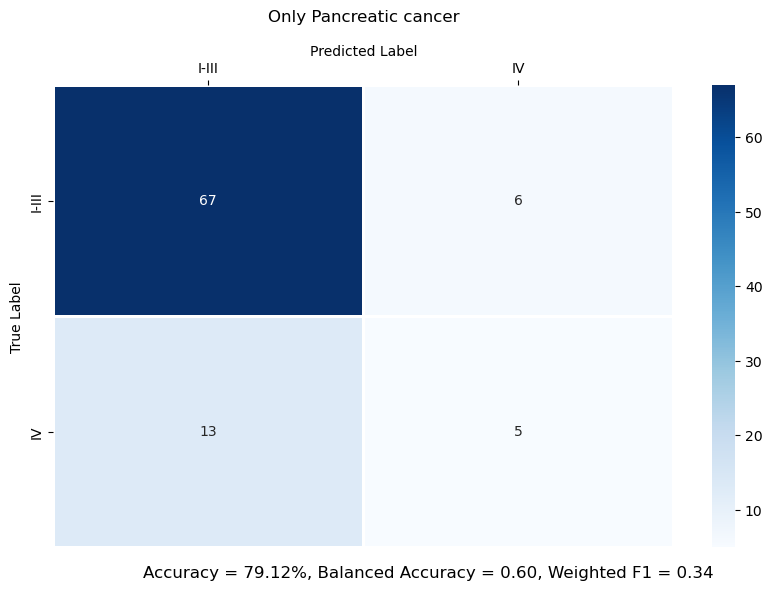

In [46]:
accuracy = accuracy_score(y_true, y_pred.astype(int))
balanced_accuracy = balanced_accuracy_score(y_true, y_pred.astype(int))
f1 = f1_score(y_true, y_pred.astype(int))
cm = confusion_matrix(y_true, y_pred.astype(int))

title = 'Only Pancreatic cancer'
scores_subtitle = f'Accuracy = {accuracy*100:.2f}%, Balanced Accuracy = {balanced_accuracy:.2f}, Weighted F1 = {f1:.2f}'

filename = f'pancreatic_cancer_only.png'
plot_confusion_matrix(cm, labels, title, scores_subtitle, output_path=os.path.join(output_dir_binary, filename))